# Определение возраста покупателей

**Дано:**
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- Контролировать добросовестность кассиров при продаже алкоголя

**Задача:**
Построить модель, которая по фотографии определит приблизительный возраст человека. Дан набор фотографий людей с указанием возраста

# Исследовательский анализ данных

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Всего 7591 фото. Пропусков в таблице нет. Средний возраст - 31 год, медианный - 29. Разброс возраста - от 1 года до 100 лет

[Text(0.5, 0, 'Возраст')]

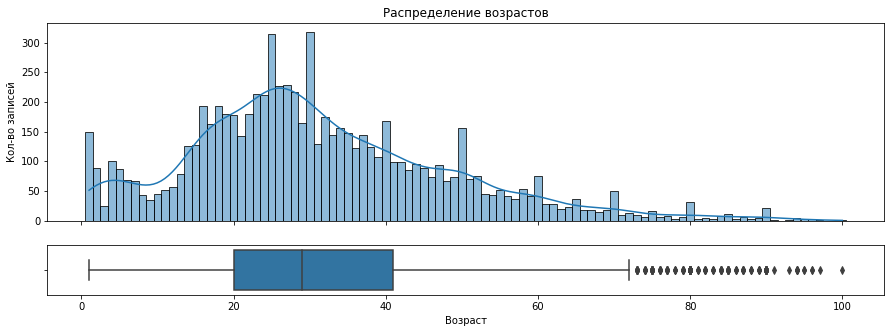

In [6]:
#строю гистограмму возрастов:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                      figsize=(15, 5), 
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[4,1]))

sns.histplot(data=df,
             x='real_age',
             discrete=True,
             kde=True,
             ax=axs_hist)\
.set(title='Распределение возрастов', ylabel='Кол-во записей')

sns.boxplot(data=df, x='real_age', ax=axs_box)\
.set(xlabel='Возраст')

Распределение похоже на нормальное, с выбросами на 25, 30, 50 годах (возможно, округление при заполнении). Больше всего людей в возрасте от 20 до 40 лет, меньше всего людей в возрасте до 9 и старше 60

Возраст: 4


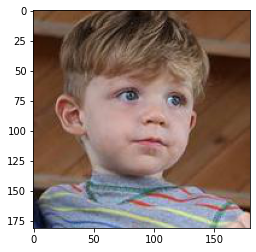

Возраст: 1


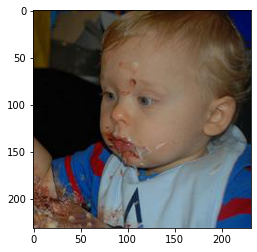

Возраст: 1


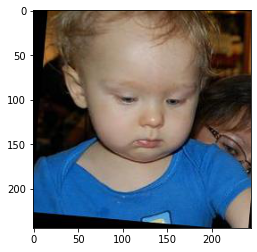

Возраст: 2


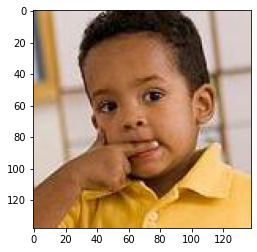

Возраст: 2


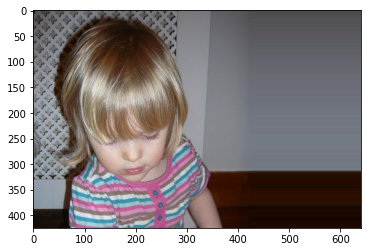

In [7]:
#смотрю на фото людей младше 5 лет
kids = df[df['real_age'] < 5]

for _, row in kids.sample(5, random_state = 10).iterrows():
    print('Возраст:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

Рандомно отобранные фото и возраст по ним похожи на правду. Есть "нестандартный" формат фото (последнее фото)

Возраст: 37


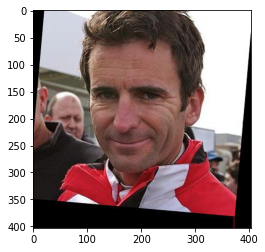

Возраст: 30


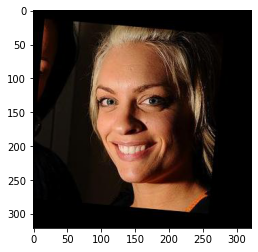

Возраст: 27


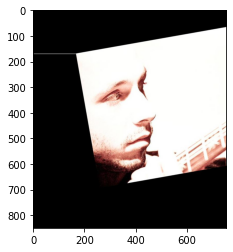

Возраст: 53


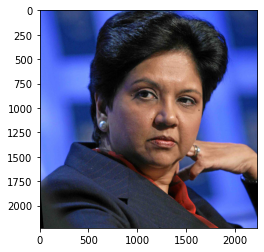

Возраст: 27


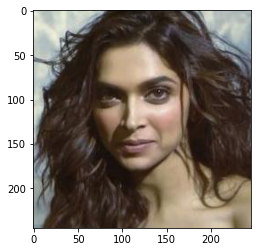

In [8]:
#смотрю на фото взрослых
adults = df.query('18 <= real_age <= 55')

for _, row in adults.sample(5, random_state = 25).iterrows():
    print('Возраст:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

И в этом случае рандомно отобранные фото и возраст по ним похожи на правду 

Возраст: 76


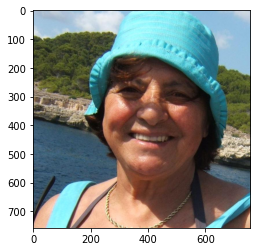

Возраст: 76


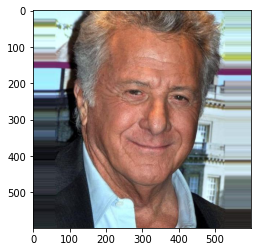

Возраст: 80


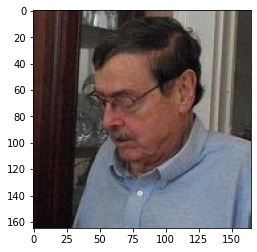

Возраст: 83


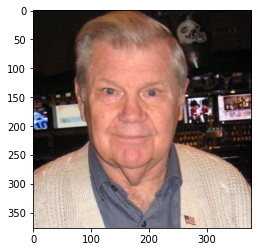

Возраст: 87


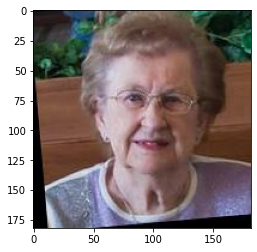

In [9]:
#смотрю фото людей старше 75 
grays = df[df['real_age'] > 75]

for _, row in grays.sample(5, random_state = 35).iterrows():
    print('Возраст:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

Фото людей старше 75 похожи на правду

Вывод по п.Исследовательский анализ данных

Есть набор фото из 7591 шт. + данные по возрасту человека на фото. Средний возраст — 31, медианный — 29, диапазон возрастов - от 1 года до 100 лет, больше всего людей 25 и 30 лет. 
Среди случайно отобранных фото не нашла неверно размеченных - общая ориентация фотографий примерно одинакова, в некоторых фото их уже повернули, чтобы выровнять положение лица, значит, их необязательно поворачивать, а начальный размер изображений отличается в силу того, что визуально заметно различное качество фото, где-то есть черные рамки. В итоге, размер изображений мы приведем к единому перед обучением модели
В целом данных достаточно

# Обучение модели

In [10]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow

In [12]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow

In [13]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

#вывод:

2022-10-22 11:31:13.054412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-10-22 11:31:13.056050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-10-22 11:31:13.883274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-22 11:31:13.893052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
2022-10-22 11:31:13.893112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
2022-10-22 11:31:13.898274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-22 11:31:13.898333: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-22 11:31:13.902565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-22 11:31:13.894894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-22 11:31:13.897157: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-22 11:31:13.893144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
Using TensorFlow backend.
2022-10-22 11:31:13.895246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-10-22 11:31:14.208209: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-10-22 11:31:14.217706: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-10-22 11:31:14.218318: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x592bcb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-22 11:31:14.218351: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-22 11:31:14.371216: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f8bfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-22 11:31:14.371262: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-10-22 11:31:14.374173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-22 11:31:14.374246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-22 11:31:14.374261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-22 11:31:14.374296: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-22 11:31:14.374310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-22 11:31:14.374324: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-22 11:31:14.374336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-22 11:31:14.374346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-22 11:31:14.379200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-10-22 11:31:14.379283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-22 11:31:14.718506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-22 11:31:14.718556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-10-22 11:31:14.718564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-10-22 11:31:14.723027: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-22 11:31:14.723077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 5s
   98304/94765736 [..............................] - ETA: 52s
  540672/94765736 [..............................] - ETA: 18s
 2228224/94765736 [..............................] - ETA: 6s 
 7553024/94765736 [=>............................] - ETA: 2s
13664256/94765736 [===>..........................] - ETA: 1s
19759104/94765736 [=====>........................] - ETA: 1s
25804800/94765736 [=======>......................] - ETA: 1s
31916032/94765736 [=========>....................] - ETA: 0s
38191104/94765736 [===========>..................] - ETA: 0s
44302336/94765736 [=============>................] - ETA: 0s
48218112/94765736 [==============>...............] - ETA: 0s
54329344/94765736 [================>.............] - ETA: 0s
59817984/94765736 [=================>............] - ETA: 0s
65437696/94765736 [===================>..........] - ETA: 0s
71106560/94765736 [=====================>........] - ETA: 0s
76906496/94765736 [=======================>......] - ETA: 0s
83034112/94765736 [=========================>....] - ETA: 0s
88784896/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-10-22 11:31:26.040984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-22 11:31:26.344030: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 207.4028 - mae: 11.0584 - val_loss: 449.8746 - val_mae: 16.1405
Epoch 2/20
356/356 - 42s - loss: 137.6117 - mae: 8.9929 - val_loss: 453.2126 - val_mae: 16.4468
Epoch 3/20
356/356 - 42s - loss: 111.1418 - mae: 8.0809 - val_loss: 241.9740 - val_mae: 10.9405
Epoch 4/20
356/356 - 42s - loss: 94.9336 - mae: 7.3948 - val_loss: 108.8330 - val_mae: 7.8008
Epoch 5/20
356/356 - 42s - loss: 77.7804 - mae: 6.7430 - val_loss: 394.1654 - val_mae: 15.6919
Epoch 6/20
356/356 - 42s - loss: 68.9894 - mae: 6.3954 - val_loss: 202.5836 - val_mae: 10.5687
Epoch 7/20
356/356 - 42s - loss: 60.1900 - mae: 5.9153 - val_loss: 103.5125 - val_mae: 7.8209
Epoch 8/20
356/356 - 42s - loss: 49.1940 - mae: 5.3457 - val_loss: 167.4284 - val_mae: 9.7714
Epoch 9/20
356/356 - 42s - loss: 42.2779 - mae: 5.0130 - val_loss: 106.0079 - val_mae: 7.8666
Epoch 10/20
356/356 - 41s - loss: 38.0411 - mae: 4.7256 - val_loss: 86.2969 - val_mae: 7.0715
Epoch 11/20
356/356 - 42s - loss: 32.4643 - mae: 4.4058 - val_loss: 104.5355 - val_mae: 7.7392
Epoch 12/20
356/356 - 41s - loss: 27.4212 - mae: 4.0397 - val_loss: 96.8217 - val_mae: 7.3172
Epoch 13/20
356/356 - 42s - loss: 24.8660 - mae: 3.8479 - val_loss: 112.3169 - val_mae: 7.6426
Epoch 14/20
356/356 - 42s - loss: 25.8830 - mae: 3.9270 - val_loss: 87.3040 - val_mae: 7.0711
Epoch 15/20
356/356 - 42s - loss: 23.4946 - mae: 3.7487 - val_loss: 87.4305 - val_mae: 7.0503
Epoch 16/20
356/356 - 43s - loss: 22.7453 - mae: 3.6824 - val_loss: 79.9439 - val_mae: 6.7120
Epoch 17/20
356/356 - 43s - loss: 20.2360 - mae: 3.4489 - val_loss: 105.1914 - val_mae: 7.7122
Epoch 18/20
356/356 - 43s - loss: 19.6606 - mae: 3.3799 - val_loss: 82.8837 - val_mae: 6.7319
Epoch 19/20
356/356 - 42s - loss: 17.8437 - mae: 3.2478 - val_loss: 132.0586 - val_mae: 8.4231
Epoch 20/20
356/356 - 42s - loss: 15.8533 - mae: 3.0748 - val_loss: 79.7634 - val_mae: 6.6919
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 79.7634 - mae: 6.6919
Test MAE: 6.6919

# Вывод

Построенная модель по фото определяет возраст с ошибкой примерно 7 лет.

Если использовать эту модель, то ее достаточно для решения первой задачи - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. И лучше, если покупателей разбивать на группы, например, с шагом 10.

Но для решения второй задачи - решение о продаже алкоголя - качества модели недостаточно. Если человеку 24 года, модель может определить его как 17-летнего и "запретить" продажу алкоголя. И тогда магазин лишится прибыли. Поэтому тут в спорных случаях можно подключить распознавание паспорта / водительского удостоверения (как в "Гроссмарте" распознается ID)